## 1. Setup & Preprocessing
a. Load GLOBEM Dataset <br>
Assumption: Provided in CSV format.


Problem Statement in more clear format adding more details.
Follow the exact format give by Greate learning in same order.

Data collection website referernce.
Details of data in 1-2 slides
Define IQR
in the format of Research Question

In [586]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import pandas as pd

In [587]:
#Data Path
DATA_DIR = '/Volumes/SanDisk/MyData/WALSHAIMl/WalshAIML/Capstone/Depression-Detection/globem-dataset-multi-year-datasets-for-longitudinal-human-behavior-modeling-generalization-1.1/Data/'
DATA_SETS = ['INS-W_1','INS-W_2','INS-W_3','INS-W_4']

In [588]:
#Load features and depression scores
data_yearly = {}

for dataset in DATA_SETS:
    features = pd.read_csv(DATA_DIR+ dataset + '/FeatureData/rapids.csv', low_memory=False)
    labels = pd.read_csv(DATA_DIR+ dataset + '/SurveyData/dep_weekly.csv')
    data_yearly[dataset] = pd.merge(features, labels[['pid', 'date', 'dep']], on=['pid', 'date'], how='inner')

In [589]:
step_col = 'f_steps:fitbit_steps_summary_rapids_mediansumsteps:14dhist'
sleep_duration_col = 'f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist'

In [590]:
user_yearly = {'INS-W_1':'INS-W_004',
               'INS-W_2':'INS-W_302',
               'INS-W_3':'INS-W_603',
               'INS-W_4':'INS-W_1003',
               }

In [591]:
def line_plot_steps_summary(data_yearly, user_yearly):
    fig, ax = plt.subplots(2,2,figsize=(14,8))
    ax = ax.flatten()
    for i,dataset in enumerate(DATA_SETS[:4]):
        data = data_yearly[dataset]
        steps_df = data[['pid','date',step_col,'dep']].copy()
        # Ensure proper datetime format
        steps_df['date'] = pd.to_datetime(steps_df['date'])
        user_id = user_yearly[dataset]
        steps_df_user = steps_df[steps_df['pid'] == user_id]
        ax[i].plot(steps_df_user['date'], steps_df_user[step_col], marker='o', linestyle='-', label='Daily Steps')
        # If depression scores are available, overlay them
        if 'dep' in steps_df_user.columns:
            depressed_days = steps_df_user[steps_df_user['dep'] == True]  # threshold example
            ax[i].scatter(depressed_days['date'], depressed_days[step_col],
                    color='red', label='Depression', zorder=5, marker='x',s=100)
        # Set labels and title
        ax[i].set_xlabel("Date")
        ax[i].set_ylabel("Step Count")
        ax[i].set_title(f"Daily Step Count Over Time - User {user_id}")
        ax[i].tick_params(axis='x', rotation=45)
        # Show legend and grid
        ax[i].legend()
        ax[i].grid(True)
    plt.tight_layout()
    plt.show()


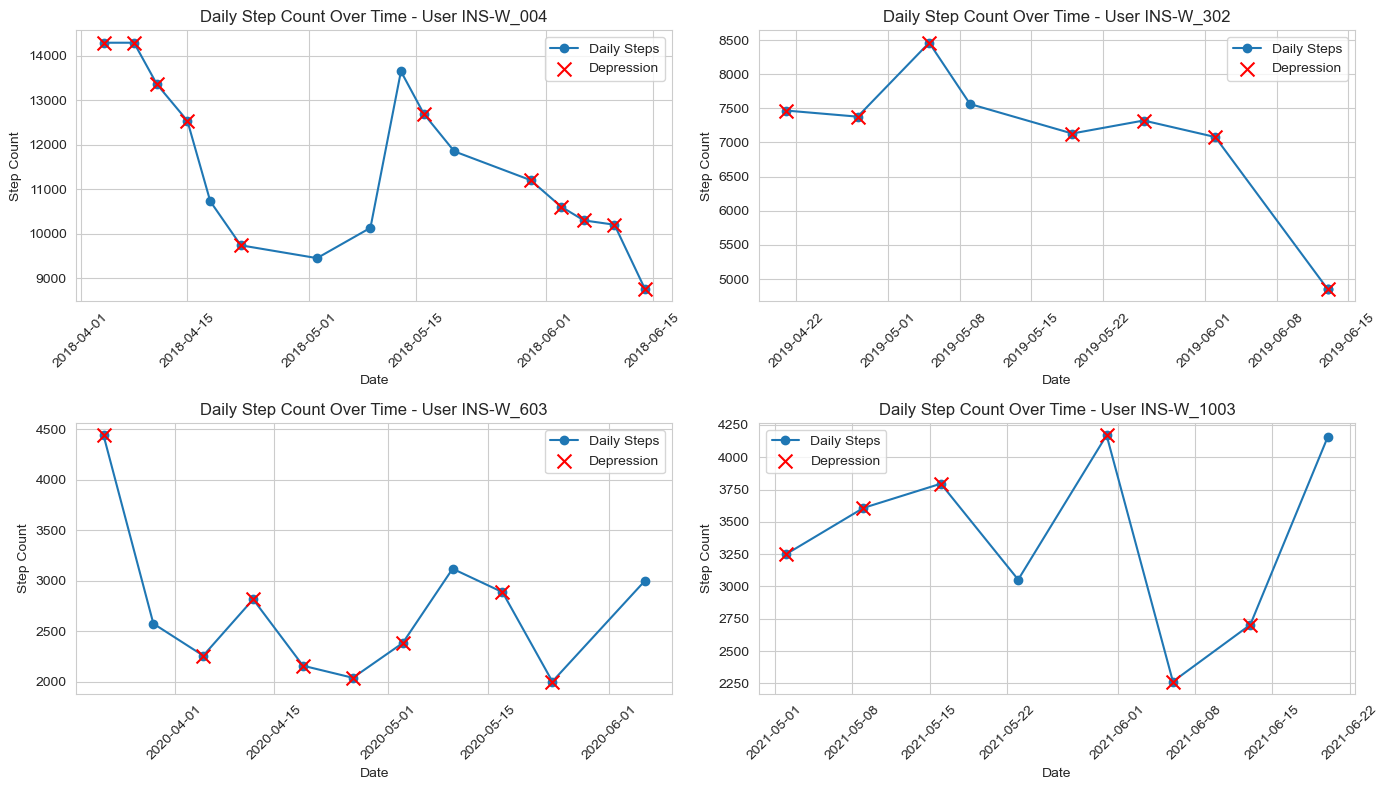

In [592]:
line_plot_steps_summary(data_yearly,user_yearly)

In [593]:
def box_plot_distrution_weekdays_weekend(data_yearly):
    fig, ax = plt.subplots(2,2,figsize=(14,8))
    ax = ax.flatten()
    for i,dataset in enumerate(DATA_SETS[:4]):
        data = data_yearly[dataset]
        sleep_df = data[['date',sleep_duration_col]].copy()
        # Ensure proper datetime format
        sleep_df['date'] = pd.to_datetime(sleep_df['date'])
        # Extract day of week (0=Monday ... 6=Sunday)
        sleep_df['day_of_week'] = sleep_df['date'].dt.dayofweek
        # Create weekday/weekend flag
        sleep_df['day_type'] = sleep_df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
        # Select only the needed columns
        sleep_duration_df = sleep_df[[sleep_duration_col, 'day_type']].dropna()
                # Prepare data for boxplot
        grouped = [
            sleep_duration_df.loc[sleep_duration_df['day_type'] == "Weekday", sleep_duration_col],
            sleep_duration_df.loc[sleep_duration_df['day_type'] == "Weekend", sleep_duration_col]
        ]
        ax[i].boxplot(grouped,tick_labels=["Weekday", "Weekend"],vert=True,
                      patch_artist=True)
        ax[i].set_title(f"Sleep Duration: Weekday vs Weekend - {dataset}")
        ax[i].set_ylabel("Sleep Duration (minutes)")
        ax[i].set_xlabel("Day Type")
        ax[i].grid(True)
    plt.tight_layout()
    plt.show()

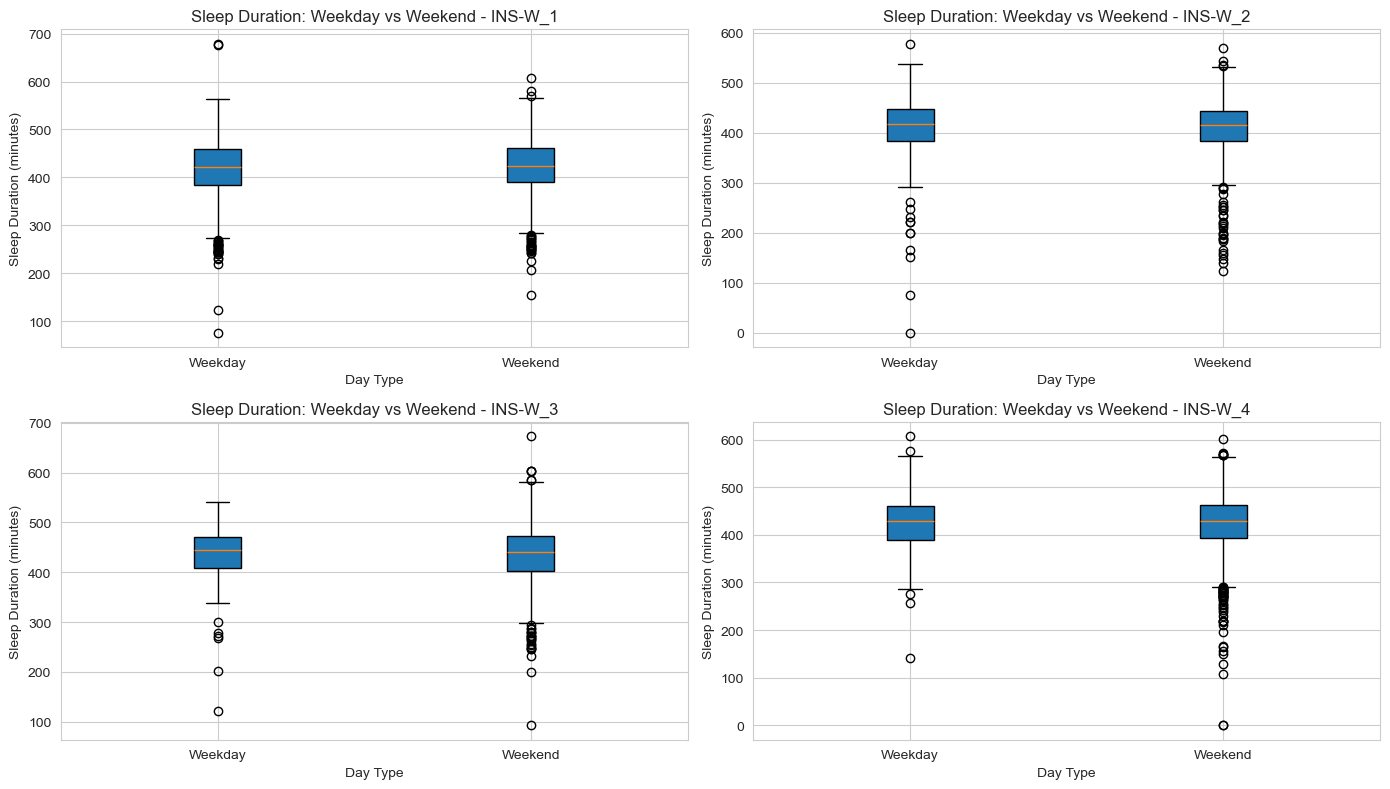

In [594]:
box_plot_distrution_weekdays_weekend(data_yearly)

In [595]:
# Pick relevant behavioral + depression columns
features = ['f_steps:fitbit_steps_summary_rapids_mediansumsteps:14dhist',
            'f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist',
            'f_screen:phone_screen_rapids_countepisodeunlock:14dhist',
            'f_call:phone_calls_rapids_outgoing_meanduration:14dhist',
            'f_call:phone_calls_rapids_incoming_meanduration:14dhist',
            'dep']

featuresdict = {
    features[0]:'dailysteps',
    features[1]:'sleep',
    features[2]:'screentime',
    features[3]:'outgoingcalltime',
    features[4]:'incomingcalltime',
    features[5]:'depression',
}

In [596]:
def draw_heat_map_behavioral_features(data_yearly):
    fig, ax = plt.subplots(2,2,figsize=(14,10))
    ax = ax.flatten()
    for i,dataset in enumerate(DATA_SETS[:4]):
        data = data_yearly[dataset]
        features_df = data[features].dropna(how='all')
        features_df = features_df.rename(columns=featuresdict)
        # Compute correlation matrix
        corr_matrix = features_df.corr(method='pearson')
        sns.heatmap(corr_matrix,ax=ax[i] ,annot=True, cmap="YlGnBu", fmt='.2f')
        ax[i].set_title(f"Correlation Matrix:Behavioral Features over depression - {dataset}")
        ax[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

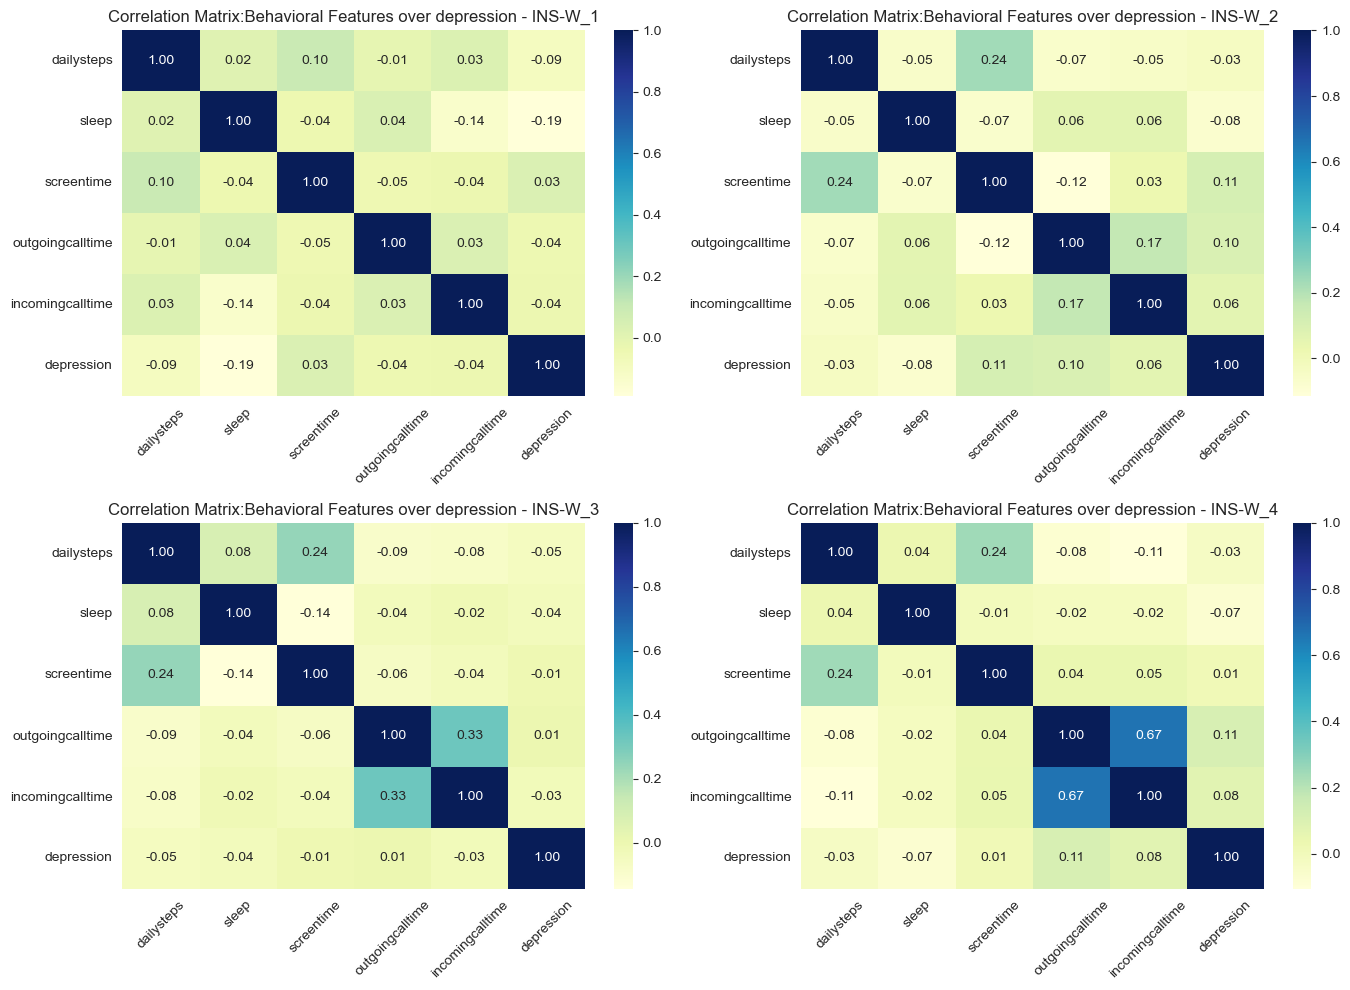

In [597]:
draw_heat_map_behavioral_features(data_yearly)

In [598]:
def draw_histogram_behavioral_features(data_yearly):
    fig, ax = plt.subplots(10,2,figsize=(12,20))
    ax = ax.flatten()
    index = 0
    for i,dataset in enumerate(DATA_SETS[:4]):
        data = data_yearly[dataset]
        features_df = data[features].dropna(how='all')
        features_df = features_df.rename(columns=featuresdict)
        values_list = list(featuresdict.values())
        X_labels = features_df[values_list[:-1]]
        y_label = values_list[-1]
        for feature in X_labels:
            sns.histplot(features_df,x=feature, ax=ax[index], bins=30,hue=y_label, kde=True, palette='viridis')
            ax[index].set_title(f"Distribution of {feature} - {dataset}")
            ax[index].grid(True)
            ax[index].set_ylabel("Frequency")
            ax[index].set_xlabel(feature)
            index += 1
    plt.tight_layout()
    plt.show()

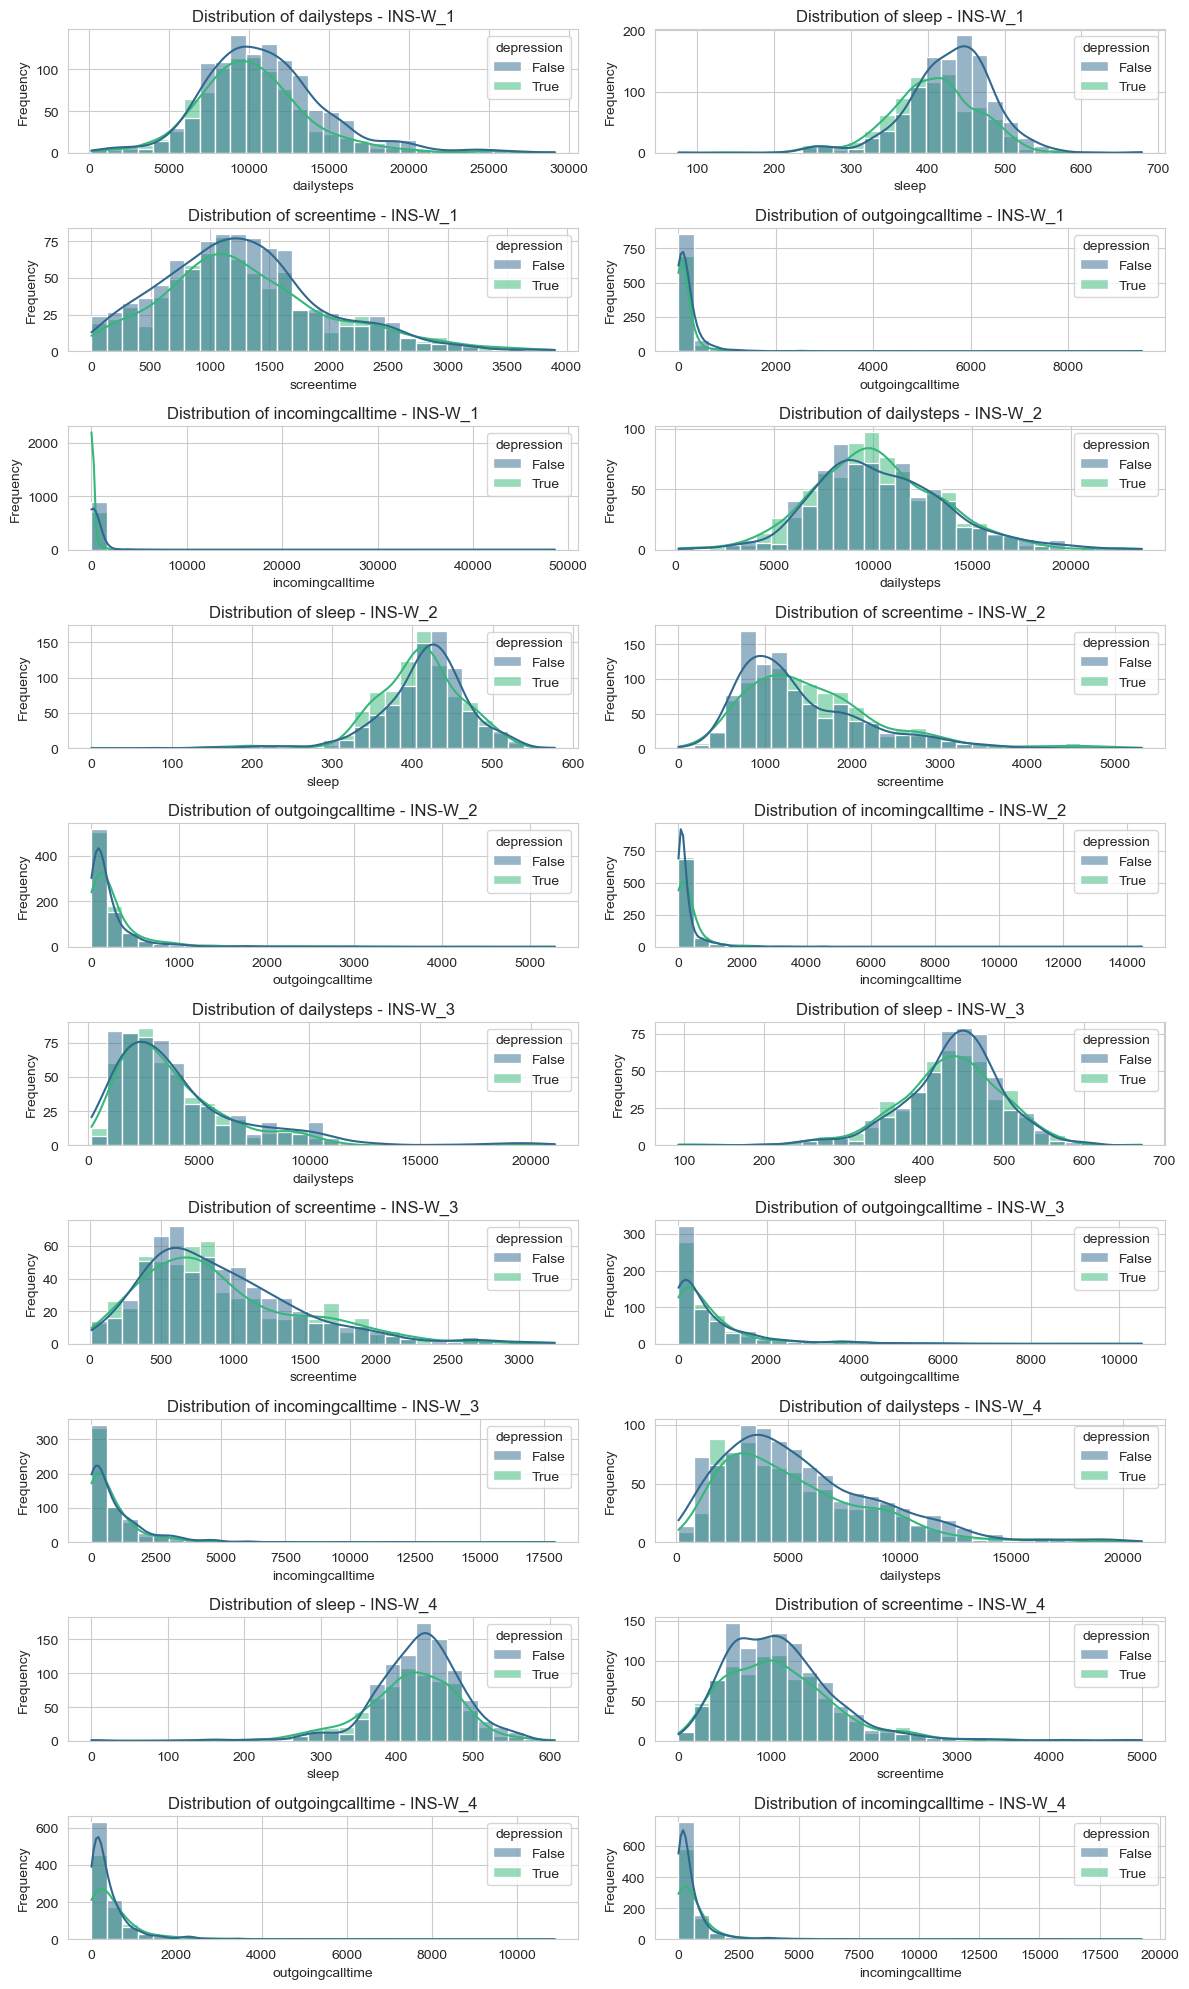

In [599]:
draw_histogram_behavioral_features(data_yearly)

In [600]:
all_data = pd.DataFrame()
for i,dataset in enumerate(DATA_SETS[:4]):
       data = data_yearly[dataset]
       features_df = data[features].dropna(how='all')
       features_df = features_df.rename(columns=featuresdict)
       features_df['dataset'] = dataset
       all_data = pd.concat([all_data,features_df], ignore_index=True)

all_data = all_data.reset_index(drop=True)
summary = all_data.groupby(['dataset','depression']).mean().reset_index()
summary = summary.round(2)
summary

,dataset,depression,dailysteps,sleep,screentime,outgoingcalltime,incomingcalltime
0,INS-W_1,False,10978.90,429.12,1271.60,194.77,399.87
1,INS-W_1,True,10256.71,406.32,1319.74,153.83,244.90
2,INS-W_2,False,10461.50,415.84,1383.57,203.24,252.80
3,INS-W_2,True,10234.27,407.23,1557.59,282.47,339.18
4,INS-W_3,False,4106.61,437.90,913.16,705.02,906.97
5,INS-W_3,True,3788.10,432.70,903.17,716.96,823.57
6,INS-W_4,False,5570.71,427.47,1097.79,408.53,521.50
7,INS-W_4,True,5348.91,418.30,1111.10,591.90,724.63


In [602]:
def features_imporance_yearly(data_yearly):
    fig, ax = plt.subplots(2,2,figsize=(12,6))
    ax = ax.flatten()
    index = 0
    for i,dataset in enumerate(DATA_SETS[:4]):
        data = data_yearly[dataset]
        features_df = data[features].dropna(how='all')
        features_df = features_df.rename(columns=featuresdict)
        # Assuming your DataFrame is named df
        # Separate features and target
        values_list = list(featuresdict.values())
        X = features_df[values_list[:-1]]
        y_label = values_list[-1]
        y = features_df[y_label]
        # Optional: scale features for better performance
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        # Split into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        # Train Random Forest
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        # Get feature importances
        importances = model.feature_importances_
        feature_names = X.columns
        # Create a DataFrame for easy viewing
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        # Plot
        sns.barplot(x='Importance', y='Feature', data=importance_df,ax=ax[index],color='blue')
        ax[index].set_title(f"Feature Importance for Depression Prediction of - {dataset}")
        ax[index].set_ylabel("Feature", fontsize=10)
        ax[index].set_xlabel('Importance Score', fontsize=10)
        index += 1
    plt.tight_layout()
    plt.show()

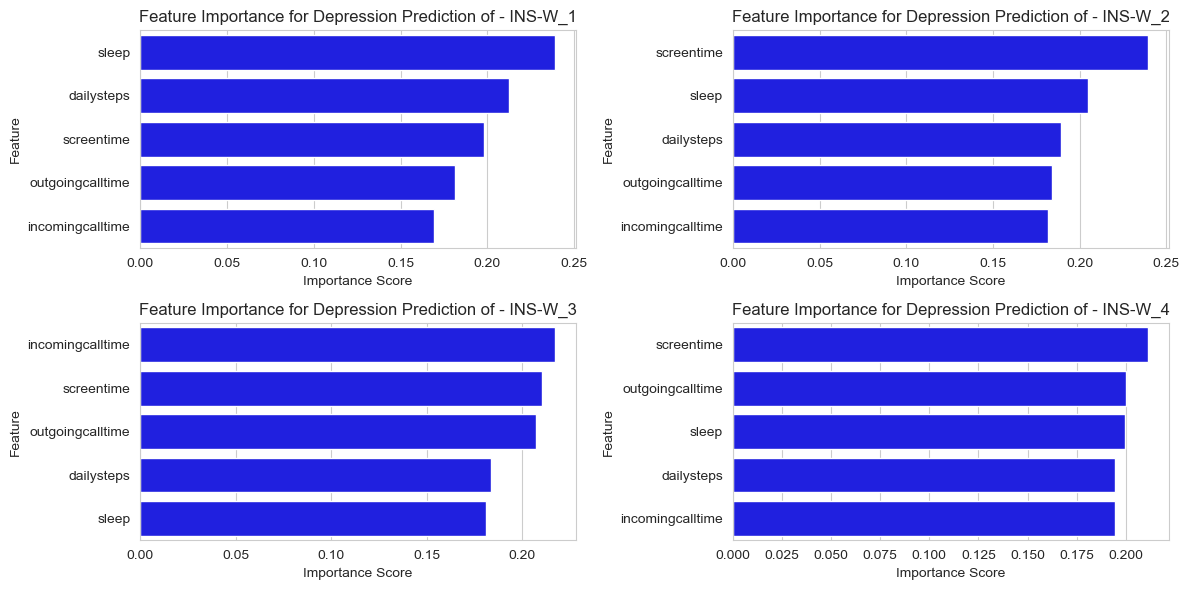

In [603]:
features_imporance_yearly(data_yearly)

## Step 2: Normalize Features (Per User)

User-level normalization is the process of transforming each user’s time-series data relative to their own historical baseline, not the entire dataset.

#### Motivation:
- Different users have different natural behaviors.
- One person might sleep 9 hours, another 6 hours — both are normal for them.
- Applying global normalization would treat this variance as noise.
- Goal: Detect deviations from personal norms, not population norms.

In [604]:
def normalize_per_user(df, user_col='pid', feature_cols=[]):
    norm_cols = {}
    for col in feature_cols:
        col_norm = df.groupby(user_col)[col].transform(
            lambda x: (x - x.median()) / (x.quantile(0.95) - x.quantile(0.05) + 1e-6)
        )
        norm_cols[col + '_norm'] = col_norm
    # Create a single new DataFrame and concatenate
    norm_df = pd.DataFrame(norm_cols)
    df = pd.concat([df.reset_index(drop=True), norm_df], axis=1)
    return df

In [605]:
def get_feature_columns(data):
    # Parse features to normalize (excluding discretized or already normalized)
    feature_cols = [col for col in data.columns if ':' in col and '_norm' not in col and '_dis' not in col]
    return feature_cols

In [606]:
def get_normalize_features_columns(feature_cols=[]):
    norm_feature_cols = [f + '_norm' for f in feature_cols]
    return norm_feature_cols

A rolling window is a technique where you take overlapping fixed-size segments from a time-series to analyze local temporal patterns.

We are working with daily passive behavioral data for each user. Instead of modeling entire time-series as a whole:
- Extract small chunks (e.g., 7 days at a time)
- Move the window forward day-by-day (or by custom steps)
- Label each window with a mood score (e.g., PHQ-4) on the last day

In [607]:
def create_rolling_windows(df, user_col='pid', window_size=2, step_size=1, feature_cols=None, label_col='dep'):
    X, y, users = [], [], []
    for pid, group in df.groupby(user_col):
        group = group.sort_values('date')
        if len(group) < window_size:
            continue
        for start in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[start:start+window_size]
            if window[label_col].isnull().any():
                continue
            X.append(window[feature_cols].values)
            y.append(window[label_col].iloc[-1])
            users.append(pid)
    return np.array(X), np.array(y), np.array(users)

In [608]:
rolling_windows_yearly = {}
def create_rolling_windows_yearly(data_yearly):
    for i,dataset in enumerate(DATA_SETS[:4]):
        start = time.time()
        data = data_yearly[dataset]
        features_column = get_feature_columns(data)
        df = normalize_per_user(data, user_col='pid', feature_cols=features_column)
        normalized_column = get_normalize_features_columns(features_column)
         # Normalize
        X, y, users = create_rolling_windows(df, feature_cols = normalized_column)
        dict = {}
        dict['X'] = X
        dict['y'] = y
        dict['users'] = users
        rolling_windows_yearly[dataset] = dict
        print(f'Rolling windows for {dataset}: {len(df)} X= {len(X)} y= {len(y)} users={len(users)} time={time.time() - start} seconds')

## Step 3: Hierarchical Temporal Contrastive Learning (HTCL)
**Hierarchical Temporal Contrastive Learning (HTCL)** is a deep learning framework designed to learn robust and personalized representations of sequential (temporal) data — particularly for behavioral modeling tasks like depression detection from smartphone-based passive sensing.

Hierarchical Temporal Contrastive Learning is a learning paradigm that uses contrastive loss at multiple temporal resolutions (hierarchies) to train models to differentiate between:
- Semantically similar sequences (e.g., the same user under similar mental states) and
- Semantically different sequences (e.g., different users or opposite mental states),
<br>
in order to learn temporally-aware, user-sensitive embeddings for downstream tasks like classification or regression.

**Key Concepts** <br>
1. Contrastive Learning
- Learns by comparing triplets: (anchor, positive, negative)
- Goal: bring anchor ↔ positive closer in latent space, and push anchor ↔ negative further apart
- Used without explicit supervision (e.g., PHQ scores may not be needed during representation learning)
2. Temporal
- Input data is sequential, e.g., 7-day behavior windows
- Patterns like sleep, activity, and phone usage evolve over time
- Model learns from temporal dependencies
3. Hierarchical
Learns from multiple temporal levels:
- Short-term windows: daily or weekly patterns
- Long-term context: across months or individuals
- Contrastive objectives are applied at different levels:
    - Intra-user contrast: different time windows of the same user
    - Inter-user contrast: compare across different users



In [609]:
# Rolling windows
create_rolling_windows_yearly(data_yearly)

Rolling windows for INS-W_1: 2360 X= 2206 y= 2206 users=2206 time=61.976900815963745 seconds
Rolling windows for INS-W_2: 2256 X= 2038 y= 2038 users=2038 time=88.09072685241699 seconds
Rolling windows for INS-W_3: 1360 X= 1224 y= 1224 users=1224 time=52.70219588279724 seconds
Rolling windows for INS-W_4: 2174 X= 1979 y= 1979 users=1979 time=77.28846216201782 seconds


The Transformer Encoder is a neural network architecture designed to handle sequential data, like: <br>
- Time-series (e.g., 7-day windows of behavior)
- Text (as in NLP)
- Sensor readings over time (as in your GLOBEM dataset)
<br>
###
Originally introduced in the "Attention is All You Need" paper (Vaswani et al., 2017), the Transformer replaces traditional RNNs (like LSTMs) with attention mechanisms, which are faster, more parallelizable, and better at modeling long-term dependencies.

| **Need**  | 	**Transformer Role**                         |
|-----------|-----------------------------------------------|
|Capture patterns over 7-day behavior windows | 	Attends to every day in the window           |
|Weigh importance of different days' behavior | 	Self-attention dynamically scores time steps |
|Model complex dependencies between signals	| Learns how sleep, activity, phone use relate  |
|Handle variable temporal relevance	| Not all days contribute equally to label      |

In the context of depression detection from time-series data:
| **Component**          | **Function**                                                                 |
|------------------------|------------------------------------------------------------------------------|
| Input Sequence         | A 7-day window of normalized behavioral features per user                    |
| Input dim            | `(batch_size, 7, input_dim)`                                                 |
| Linear Embedding       | Projects raw input features into a higher-dimensional latent space           |
| Positional Encoding    | Adds day-wise order info to each time step (since Transformers are orderless)|
| Multi-Head Attention   | Learns dependencies between all days in the sequence                         |
| Feed-Forward Layer     | Applies nonlinear transformation to each time step                           |
| Encoder Layer Stack    | Multiple layers of attention + feed-forward blocks                           |
| Output Sequence        | Contextualized representation of each day in the window                      |
| Output Shape           | `(batch_size, 7, model_dim)`                                                 |
| Usage in Model         | Final day’s output (e.g., `x[:, -1, :]`) is passed to classification layers  |


In [610]:
import torch
import torch.nn as nn
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = nn.Parameter(torch.randn(100, model_dim))  # Up to 100-day sequences
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):  # (B, T, F)
        x = self.embedding(x) + self.pos_encoder[:x.size(1)]
        x = x.permute(1, 0, 2)  # (T, B, F)
        return self.transformer(x).permute(1, 0, 2)  # (B, T, F)


The Triplet Loss is central to your temporal contrastive learning approach.
It's used to learn better representations by enforcing that: <br>

**“Samples from the same user and mood state are closer together than samples from different users or mood states.”**

Triplet Loss compares:
- Anchor: a sample (e.g., a 7-day window)
- Positive: a sample similar to anchor (same user or same label)
- Negative: a dissimilar sample (different user or opposite label)

| **Term**       | **Meaning**                                                                 |
|----------------|------------------------------------------------------------------------------|
| Anchor         | Input window to be learned                                                  |
| Positive       | Similar window (same user/label)                                            |
| Negative       | Dissimilar window (different user or label)                                 |
| Distance       | Cosine or Euclidean (usually cosine in behavior models)                     |
| Margin         | Minimum gap enforced between positive and negative pairs (e.g., 0.2)        |
| Loss Goal      | Push anchor closer to positive, farther from negative                       |
| Use Case       | Self-supervised representation learning for personalized behavior modeling  |



In [611]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)

The ContextDecoder is a neural module that transforms contextual metadata (e.g., "is weekend", "is during COVID", etc.) into a vector representation that can be fused with the behavior sequence encoding.
**Human behavior is context-dependent — the same sleep pattern on a Monday vs. Saturday may mean different things.**

|**Component**|**Meaning**|
|--------|---------|
|Input	| A vector like [0, 1, 1] → weekend, COVID, holiday|
|Output	| A latent vector like [0.3, -0.5, 1.2, ...] |
| Role	| Provides context-aware information to the model |

In [612]:
class ContextDecoder(nn.Module):
    def __init__(self, context_dim, model_dim):
        super().__init__()
        self.embedding = nn.Embedding(context_dim, model_dim)

    def forward(self, context_ids):  # (B, C)
        return self.embedding(context_ids)  # (B, C, D)


The PersonalizedAdapter is a learnable transformation layer designed to personalize the model’s behavior to individual users. <br>

In depression detection: <br>
Each person has different baselines and behavioral patterns. <br>
A model trained globally might miss subtle personal signals. <br>
The PersonalizedAdapter helps tune the shared model’s outputs to better fit an individual user. <br>

Why It Helps in Depression Detection

|**Problem**|**Adapter Solution**|
|-------|--------|
|One model can't fit all users|	Learns user-specific representation shift|
|Subtle differences ignored|	Emphasizes deviations based on personal patterns|
|Context alone is not enough|	Personal embedding + context improves generalization|


In [613]:
#This is a parameterized neural module that learns a transformation of the input representation — it's essentially a bottleneck projection + expansion, applied identically to all samples.
#This design is commonly called a "bottleneck adapter" — it's popular in NLP models (like BERT adapters) and meta-learning setups.
#It is helpful in
## Keeps parameter count low
## Allows quick adaptation with few gradients
## Prevents overfitting by acting like a regularized attention shift

class PersonalizedAdapter(nn.Module):
    def __init__(self, model_dim, bottleneck_dim):
        super().__init__()
        self.adapter = nn.Sequential(
            nn.Linear(model_dim, bottleneck_dim),  #shrink
            nn.ReLU(),                             #non linearity
            nn.Linear(bottleneck_dim, model_dim)   #expand
        )

    def forward(self, x):
        return self.adapter(x)

This is a simple linear classifier that takes a feature vector (e.g., from your Transformer + context + adapter) and outputs logits for binary classification — predicting:
- Class 0: Non-depressed
- Class 1: Depressed

In [614]:
class DepressionClassifier(nn.Module):
    def __init__(self, model_dim):
        super().__init__()
        self.classifier = nn.Linear(model_dim, 2)

    def forward(self, x):
        return self.classifier(x)

### Full Pipeline
- Sequence of user behavior → encoded via Transformer
- Context + personalization → added via adapters
- Resulting vector → fed to this DepressionClassifier
- Outputs logits → passed to loss or softmax

In [615]:
class DepressionDetectionModel(nn.Module):
    def __init__(self, input_dim, context_dim, model_dim, bottleneck_dim, nhead=2, num_layers=2):
        super().__init__()
        self.encoder = TransformerEncoder(input_dim, model_dim, nhead, num_layers)
        self.context_decoder = ContextDecoder(context_dim, model_dim)
        self.adapter = PersonalizedAdapter(model_dim, bottleneck_dim)
        self.classifier = DepressionClassifier(model_dim)

    def forward(self, x, context_ids):
        encoded_seq = self.encoder(x)                  # (B, T, D)
        sequence_repr = encoded_seq[:, -1, :]          # (B, D), last token

        context_repr = self.context_decoder(context_ids)  # (B, D)
        fused = sequence_repr + context_repr            # (B, D)

        personalized = self.adapter(fused)              # (B, D)
        logits = self.classifier(personalized)          # (B, 2)
        return logits

This is a standard PyTorch training function that:

- Takes a model, dataloader, optimizer, and number of epochs
- Runs forward and backward passes
- Updates weights using classification loss
- Tracks and prints the average loss per epoch

In [616]:
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def train(model, dataloader, optimizer, epochs):
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, context_ids, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            context_ids = context_ids.to(device)
            # Forward pass
            logits = model(x, context_ids)
            # Classification loss
            loss = F.cross_entropy(logits, y)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(dataloader):.4f}")

Using device: cpu


In [617]:
import torch
from torch.utils.data import DataLoader, TensorDataset
def getDataLoader(dataset, X,y):
    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)     # (N, 7, D)
    y_tensor = torch.tensor(y, dtype=torch.long)        # classification (0/1)
    print(f"Is NAN exist {torch.isnan(X_tensor).any()} in {dataset}")   # True → problem
    print(f"Is INF exist {torch.isinf(X_tensor).any()} in {dataset}")   # True → problem
    X_tensor[torch.isnan(X_tensor)] = 0.0
    X_tensor[torch.isinf(X_tensor)] = 0.0
    print(f"Unquie Y in tensor {torch.unique(y_tensor)} in {dataset}")  # Should be [0, 1]
    context_ids_tensor = torch.zeros_like(y_tensor)     # placeholder for now
    # Dataset & DataLoader
    dataset = TensorDataset(X_tensor, context_ids_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    return dataloader,X_tensor,y_tensor,context_ids_tensor

In [618]:
model_data_yearly = {}
for dataset, rolling_windows in rolling_windows_yearly.items():
    X = rolling_windows['X']
    y = rolling_windows['y']
    dataloader,X_tensor,y_tensor,context_ids_tensor = getDataLoader(dataset,X,y)
    print(f'***** Starting training for dataset {dataset} *****')
    model = DepressionDetectionModel(
        input_dim=X.shape[2],       # number of normalized features per day
        context_dim=10,             # number of context tokens (e.g., weekend, COVID, etc.)
        model_dim=128,
        bottleneck_dim=32,
        nhead=4,
        num_layers=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    train(model, dataloader, optimizer, epochs=10)
    dict = {}
    dict['model'] = model
    dict['optimizer'] = optimizer
    dict['dataloader'] = dataloader
    dict['X_tensor'] = X_tensor
    dict['y_tensor'] = y_tensor
    dict['context_ids_tensor'] = context_ids_tensor
    model_data_yearly[dataset] = dict

Is NAN exist True in INS-W_1
Is INF exist False in INS-W_1
Unquie Y in tensor tensor([0, 1]) in INS-W_1
***** Starting training for dataset INS-W_1 *****
Epoch 1/10 - Loss: 0.6898
Epoch 2/10 - Loss: 0.6857
Epoch 3/10 - Loss: 0.6827
Epoch 4/10 - Loss: 0.6665
Epoch 5/10 - Loss: 0.6480
Epoch 6/10 - Loss: 0.6155
Epoch 7/10 - Loss: 0.5961
Epoch 8/10 - Loss: 0.5745
Epoch 9/10 - Loss: 0.5532
Epoch 10/10 - Loss: 0.5384
Is NAN exist True in INS-W_2
Is INF exist False in INS-W_2
Unquie Y in tensor tensor([0, 1]) in INS-W_2
***** Starting training for dataset INS-W_2 *****
Epoch 1/10 - Loss: 0.6941
Epoch 2/10 - Loss: 0.6918
Epoch 3/10 - Loss: 0.6890
Epoch 4/10 - Loss: 0.6756
Epoch 5/10 - Loss: 0.6561
Epoch 6/10 - Loss: 0.6155
Epoch 7/10 - Loss: 0.5876
Epoch 8/10 - Loss: 0.5569
Epoch 9/10 - Loss: 0.5497
Epoch 10/10 - Loss: 0.5146
Is NAN exist True in INS-W_3
Is INF exist False in INS-W_3
Unquie Y in tensor tensor([0, 1]) in INS-W_3
***** Starting training for dataset INS-W_3 *****
Epoch 1/10 - Los

In [619]:
report_data = []
for dataset, data_tensor in model_data_yearly.items():
    model = data_tensor['model']
    X_tensor = data_tensor['X_tensor']
    y_tensor = data_tensor['y_tensor']
    context_ids_tensor = data_tensor['context_ids_tensor']
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor.to(device), context_ids_tensor.to(device)).argmax(dim=1).cpu()
        print(f"Classification Report for {dataset}")
        print(classification_report(y_tensor, y_pred))
        print("******************************************")
        dict = {}
        dict['dataset'] = dataset
        dict['accuracy'] = accuracy_score(y_tensor, y_pred)
        dict['precision'] = precision_score(y_tensor, y_pred)
        dict['recall'] = recall_score(y_tensor, y_pred)
        dict['f1'] = f1_score(y_tensor, y_pred)
        report_data.append(dict)

Classification Report for INS-W_1
              precision    recall  f1-score   support

           0       0.69      0.93      0.79      1219
           1       0.85      0.48      0.61       987

    accuracy                           0.73      2206
   macro avg       0.77      0.71      0.70      2206
weighted avg       0.76      0.73      0.71      2206

******************************************
Classification Report for INS-W_2
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1003
           1       0.80      0.80      0.80      1035

    accuracy                           0.80      2038
   macro avg       0.80      0.80      0.80      2038
weighted avg       0.80      0.80      0.80      2038

******************************************
Classification Report for INS-W_3
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       644
           1       0.76      0.89      0.82      

In [620]:
report_df = pd.DataFrame(report_data)
report_df

,dataset,accuracy,precision,recall,f1
0,INS-W_1,0.730281,0.853791,0.479230,0.613887
1,INS-W_2,0.797350,0.803711,0.795169,0.799417
2,INS-W_3,0.817810,0.762115,0.894828,0.823156
3,INS-W_4,0.783729,0.780275,0.712657,0.744934


In [621]:
def draw_confusion_matrix():
    fig, ax = plt.subplots(2,2,figsize=(12,8))
    ax = ax.flatten()
    index = 0
    for dataset, data_tensor in model_data_yearly.items():
        model = data_tensor['model']
        X_tensor = data_tensor['X_tensor']
        y_tensor = data_tensor['y_tensor']
        context_ids_tensor = data_tensor['context_ids_tensor']
        with torch.no_grad():
            logits = model(X_tensor.to(device), context_ids_tensor.to(device))
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
            preds = np.round(probs)                                   # Threshold at 0.5
            y_true = y_tensor.numpy()
            cm = confusion_matrix(y_true, preds)
            sns.heatmap(cm,ax=ax[index], annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Depressed', 'Depressed'],
            yticklabels=['Non-Depressed', 'Depressed'])
            ax[index].set_title(f"Confusion matrix of - {dataset}")
            ax[index].set_ylabel("True Label", fontsize=10)
            ax[index].set_xlabel('Predicted Label', fontsize=10)
            index += 1
    plt.tight_layout()
    plt.show()

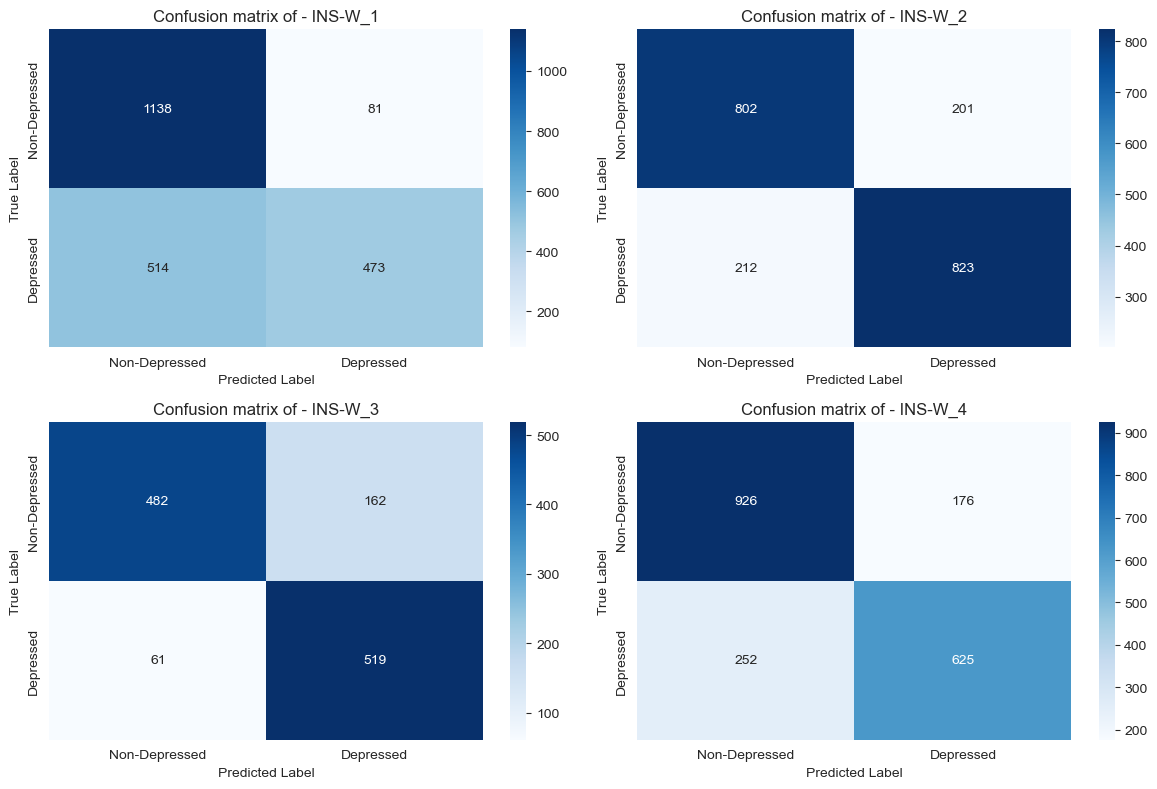

In [622]:
draw_confusion_matrix()

Positive <br>
This is critical in depression detection, where false negatives are dangerous. <br>
AUC and F1-score for class 1 are decent, suggesting the model does learn depression-specific patterns. <br>

Need Attention <br>
The model misses most non-depressed users Recall = 0.22 <br>
That means it's over-predicting depression, i.e., it tends to say everyone is depressed unless the signal is clearly otherwise.

Suggestion <br>
- Class Imbalnces or Bias
- Add more data example : Merge INS_W1, INS_W2, INS_w3 etc..

In [623]:
def draw_roc_auc_plot():
    fig, ax = plt.subplots(2,2,figsize=(12,8))
    ax = ax.flatten()
    index = 0
    for dataset, data_tensor in model_data_yearly.items():
        model = data_tensor['model']
        X_tensor = data_tensor['X_tensor']
        y_tensor = data_tensor['y_tensor']
        context_ids_tensor = data_tensor['context_ids_tensor']
        with torch.no_grad():
            logits = model(X_tensor.to(device), context_ids_tensor.to(device))
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
            preds = np.round(probs)                                   # Threshold at 0.5
            y_true = y_tensor.numpy()
            fpr, tpr, thresholds = roc_curve(y_true, probs)
            roc_auc = auc(fpr, tpr)
            ax[index].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
            ax[index].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            ax[index].set_xlabel('False Positive Rate', fontsize=10)
            ax[index].set_ylabel('True Positive Rate', fontsize=10)
            ax[index].set_title(f'Receiver Operating Characteristic-{dataset}')
            ax[index].legend(loc="lower right")
            index += 1
    plt.tight_layout()
    plt.show()

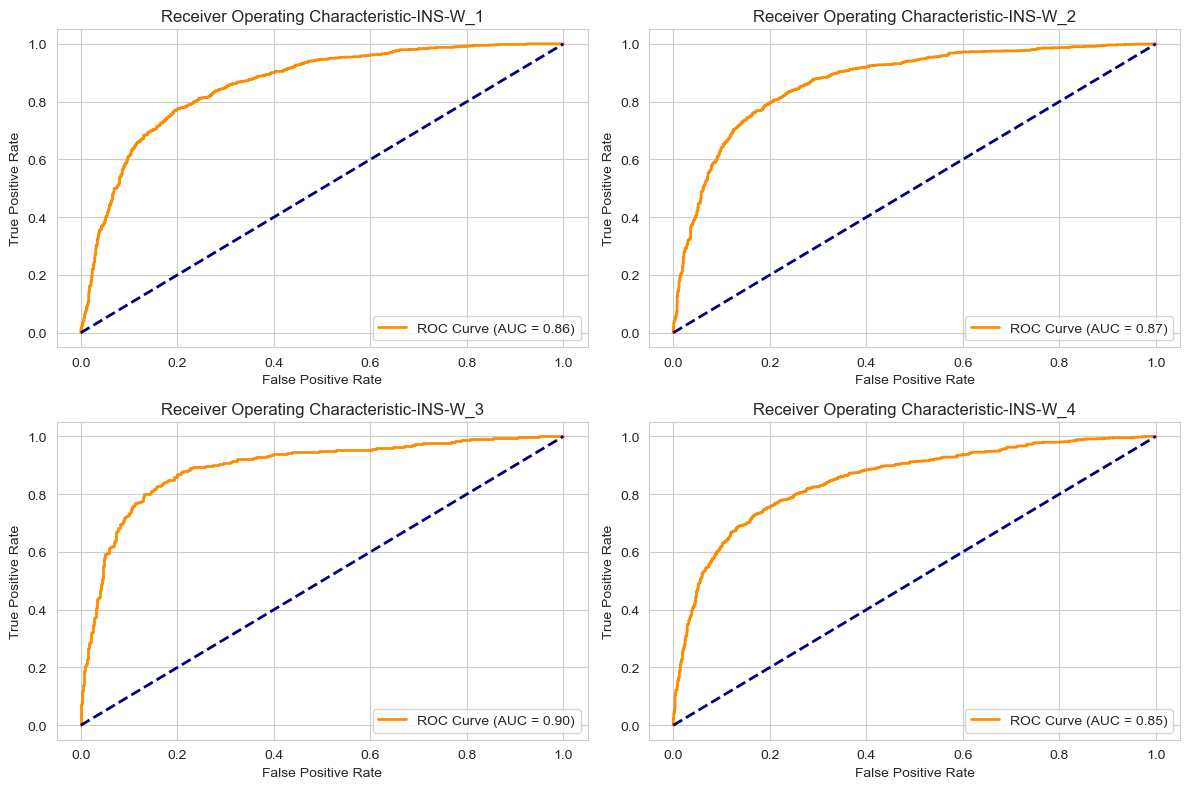

In [624]:
draw_roc_auc_plot()